# Evaluation of Neuromni  
This notebook investigates the latency of our Neuromni implementation by analyzing the results of our client simulator.

Simulations in the `axon_dir` were run using the following supervoxels (displaying their roots):  
https://neuromancer-seung-import.appspot.com/#!{'layers':{'img':{'type':'image'_'source':'precomputed://gs://neuroglancer/ranl/basil_4k/img'}_'seg_251':{'type':'segmentation'_'source':'precomputed://gs://neuroglancer/ranl/basil_4k_oldnet/seg_25'_'chunkedGraph':null_'segments':['1073903143'_'1074064901'_'1074336701'_'1074467139'_'117563'_'1342233232'_'1342308999'_'1610706931'_'1610781844'_'1610940034'_'1611246832'_'1879168200'_'1879250635'_'2147525944'_'2147614248'_'2147629746'_'2147841511'_'2416117561'_'2416123787'_'2416144986'_'2416340003'_'2416397214'_'268512186'_'268797368'_'268883386'_'268946903'_'268961635'_'2953154793'_'2953255939'_'3221313118'_'3221329220'_'3222159928'_'3489764604'_'3489776183'_'3758544591'_'3758698198'_'4026574616'_'4026625058'_'4026645911'_'4027058406'_'515571'_'536939013'_'537146838'_'543481'_'77282'_'805731487'_'805785857'_'806134340'_'806219286']}_'ws1':{'type':'segmentation'_'source':'precomputed://gs://neuroglancer/ranl/basil_4k_oldnet/ws'_'chunkedGraph':null_'segments':['1073831040'_'1073872745'_'1342240712'_'1342265248'_'2147609338'_'2415958393'_'2416091572'_'3221347192'_'3221368509'_'3489774991'_'3489779429'_'4026569708'_'4026600005'_'805452577'_'805475912']}}_'navigation':{'pose':{'position':{'voxelSize':[8_8_40]_'voxelCoordinates':[948.10986328125_139.1175079345703_19.42513084411621]}}_'zoomFactor':6.25041031438732}_'perspectiveOrientation':[0.1268017739057541_0.8850617408752441_-0.13427391648292542_-0.42726749181747437]_'perspectiveZoom':335.217060767006_'showSlices':false_'layout':'xy-3d'}

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import expanduser, join

In [22]:
data_dir = join(os.getcwd(), 'data')
axon_dir = join(data_dir, 'axons')
dend_dir = join(data_dir, 'dendrites')
runtime = 120

In [28]:
def get_filename(num_readers, num_writers, runtime, client=True):
    tag = 'clients' if client else 'receiver'
    return'NeuromniSimulator_{0}_readers_{1}_writers_{2}_seconds_{3}'.format(num_readers, num_writers, runtime, tag)

## Individual simulation functions

In [118]:
def separate_read_write(df):
    read_df = df[df['op'].isin(['root', 'subgraph'])]
    write_df = df[~(df['op'].isin(['root', 'subgraph']))]
    return read_df, write_df

In [45]:
def merge_client_receiver(c_write_df, r_df):
    return pd.merge(c_write_df, r_df, how='outer', on=['op','v1','v2'])

In [157]:
def load_scenario(num_readers, num_writers, runtime=runtime):
    c_df = pd.read_csv(join(axon_dir, get_filename(num_readers,num_writers,runtime, client=True)))
    r_df = pd.read_csv(join(axon_dir, get_filename(num_readers,num_writers,runtime, client=False)))
    c_read_df, c_write_df = separate_read_write(c_df)
    return c_read_df, merge_client_receiver(c_write_df, r_df)

In [126]:
def separate_merge_split(df):
    merge_df = df[df['op'] == 'merge']
    split_df = df[df['op'] == 'split']
    return merge_df, split_df

In [136]:
def separate_root_subgraph(df):
    root_df = df[df['op'] == 'root']
    subgraph_df = df[df['op'] == 'subgraph']
    return root_df, subgraph_df

In [65]:
def write_latency(df):
    df['master_queue'] = df['graph_start'] - df['master_start']
    df['graph_processing'] = df['graph_stop'] - df['graph_start']
    df['master_processing'] = df['master_queue'] + df['graph_processing']
    df['client_communication'] = df['client_receipt'] - df['client_request'] - df['master_processing']
    df['receiver_communication'] = df['receiver_receipt'] - df['client_receipt']
    return df[['id','op','v1','v2','master_queue','graph_processing',
               'master_processing','client_communication','receiver_communication']]

In [133]:
def read_latency(df):
    df['master_queue'] = df['graph_start'] - df['master_start']
    df['graph_processing'] = df['graph_stop'] - df['graph_start']
    df['master_processing'] = df['master_queue'] + df['graph_processing']
    df['client_communication'] = df['client_receipt'] - df['client_request'] - df['master_processing']
    return df[['id','op','v1','v2','master_queue','graph_processing',
               'master_processing','client_communication']]

In [141]:
def get_latency(num_readers, num_writers, read_requests=False):
    read_df, write_df = load_scenario(num_readers=num_readers,num_writers=num_writers)
    if read_requests:
        read_latency(read_df)
        return separate_root_subgraph(read_df)
    else:
        write_latency(write_df)
        return separate_merge_split(write_df)        

## Summary functions

In [139]:
def plot_latency(axis_pair, num_readers, num_writers, read_requests=False):
    latencyA, latencyB = get_latency(num_readers, num_writers, read_requests=read_requests)
    if read_requests:
        cols = ['master_queue','graph_processing','client_communication']
        titleA, titleB = 'root', 'subgraph'
    else:
        cols = ['master_queue','graph_processing','client_communication','receiver_communication']
        titleA, titleB = 'merge', 'split'
    axis_pair[0].set_ylabel('seconds')
    axis_pair[0].set_title('{0} {1}'.format(titleA, (num_readers, num_writers)))
    axis_pair[1].set_title('{0} {1}'.format(titleB, (num_readers, num_writers)))
    latencyA[cols].plot.bar(stacked=True, ax=axis_pair[0])
    latencyB[cols].plot.bar(stacked=True, ax=axis_pair[1], legend=False)

In [189]:
def compile_means(num_readers_list, num_writers_list, read_requests=False):
    dfA = pd.DataFrame()
    dfB = pd.DataFrame()
    
    def append_mean(df, incoming_df, num_readers, num_writers):
        m = incoming_df.mean()
        m['num_readers'] = num_readers
        m['num_writers'] = num_writers
        return df.append(m, ignore_index=True)
    
    if read_requests:
        cols = ['master_queue','graph_processing','client_communication']
    else:
        cols = ['master_queue','graph_processing','client_communication','receiver_communication']
    
    for num_readers, num_writers in zip(num_readers_list, num_writers_list):
        latencyA, latencyB = get_latency(num_readers, num_writers, read_requests=read_requests)
        dfA = append_mean(dfA, latencyA[cols], num_readers, num_writers)
        dfB = append_mean(dfB, latencyB[cols], num_readers, num_writers)
        
    return dfA, dfB

## Compiled latency

In [205]:
df_merge_high, df_split_high = compile_means([0 for i in range(8)], [(i+1)*2 for i in range(8)])
df_merge_low, df_split_low = compile_means([(i+1)*2-1 for i in range(8)], [1 for i in range(8)])

In [243]:
df_root_high, df_subgraph_high = compile_means([0 for i in range(8)], [(i+1)*2 for i in range(8)], read_requests=True)
df_root_low, df_subgraph_low = compile_means([(i+1)*2-1 for i in range(8)], [1 for i in range(8)], read_requests=True)

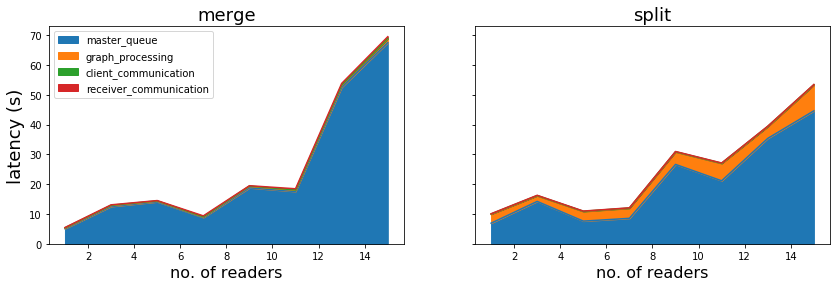

In [238]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,4), facecolor='white')
cols = ['num_readers','master_queue','graph_processing','client_communication','receiver_communication']
# fig.suptitle('high-read', fontsize=24)
axes[0].set_ylabel('latency (s)', fontsize=18)
axes[0].set_title('merge', fontsize=18)
axes[1].set_title('split', fontsize=18)
df_merge_low[cols].plot(kind='area', x='num_readers', ax=axes[0])
axes[0].set_xlabel('no. of readers', fontsize=16)
df_split_low[cols].plot(kind='area', x='num_readers', ax=axes[1], legend=False)
axes[1].set_xlabel('no. of readers', fontsize=16)
plt.show()

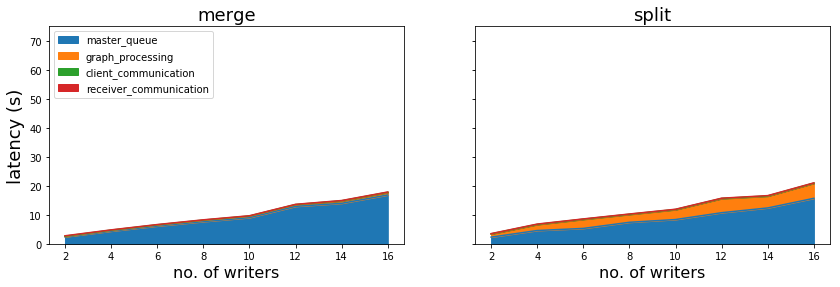

In [254]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,4), facecolor='white')
cols = ['num_writers','master_queue','graph_processing','client_communication','receiver_communication']
# fig.suptitle('high-read', fontsize=24)
axes[0].set_ylabel('latency (s)', fontsize=18)
axes[0].set_ylim(top=75)
axes[0].set_title('merge', fontsize=18)
axes[1].set_title('split', fontsize=18)
df_merge_high[cols].plot(kind='area', x='num_writers', ax=axes[0])
axes[0].set_xlabel('no. of writers', fontsize=16)
axes[0].legend(loc=2)
df_split_high[cols].plot(kind='area', x='num_writers', ax=axes[1], legend=False)
axes[1].set_xlabel('no. of writers', fontsize=16)
plt.show()

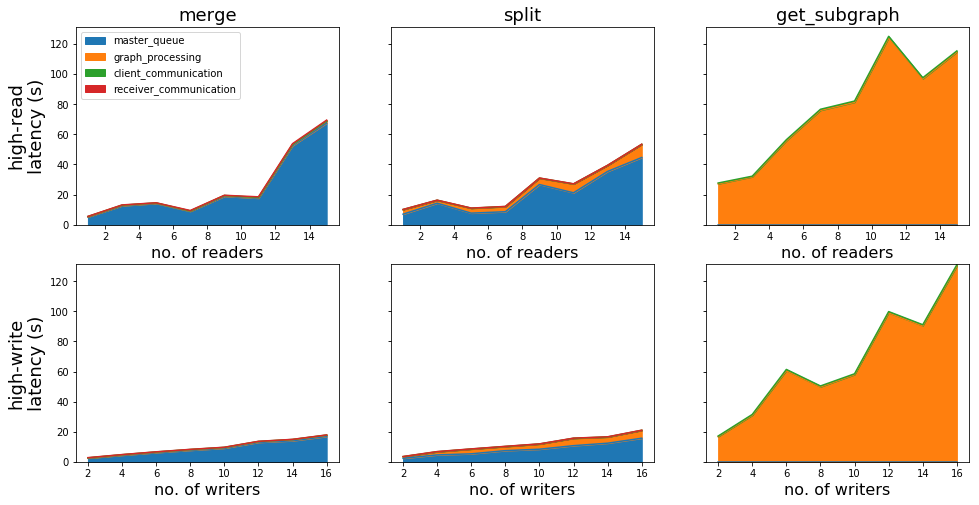

In [267]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(16,8), facecolor='white')
axes[0][0].set_ylabel('high-read\nlatency (s)', fontsize=18)
axes[0][0].set_title('merge', fontsize=18)
axes[0][1].set_title('split', fontsize=18)
axes[0][2].set_title('get_subgraph', fontsize=18)
cols = ['num_readers','master_queue','graph_processing','client_communication']
df_subgraph_low[cols].plot(kind='area', x='num_readers', ax=axes[0][2], legend=False)
axes[0][2].set_xlabel('no. of readers', fontsize=16)
cols = ['num_readers','master_queue','graph_processing','client_communication','receiver_communication']
df_merge_low[cols].plot(kind='area', x='num_readers', ax=axes[0][0])
axes[0][0].set_xlabel('no. of readers', fontsize=16)
df_split_low[cols].plot(kind='area', x='num_readers', ax=axes[0][1], legend=False)
axes[0][0].legend(loc=2)
axes[0][1].set_xlabel('no. of readers', fontsize=16)
cols = ['num_writers','master_queue','graph_processing','client_communication']
df_subgraph_high[cols].plot(kind='area', x='num_writers', ax=axes[1][2], legend=False)
axes[1][2].set_xlabel('no. of writers', fontsize=16)
cols = ['num_writers','master_queue','graph_processing','client_communication','receiver_communication']
axes[1][0].set_ylabel('high-write\nlatency (s)', fontsize=18)
df_merge_high[cols].plot(kind='area', x='num_writers', ax=axes[1][0], legend=False)
axes[1][0].set_xlabel('no. of writers', fontsize=16)
df_split_high[cols].plot(kind='area', x='num_writers', ax=axes[1][1], legend=False)
axes[1][1].set_xlabel('no. of writers', fontsize=16)
plt.show()

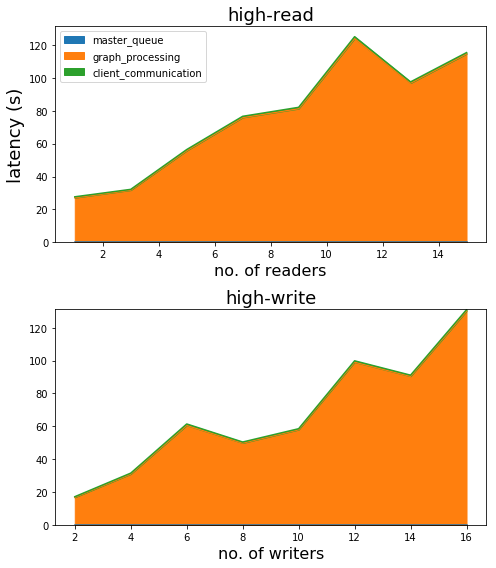

In [256]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(7,8), facecolor='white')
cols = ['num_readers','master_queue','graph_processing','client_communication']
# fig.suptitle('high-read', fontsize=24)
axes[0].set_ylabel('latency (s)', fontsize=18)
axes[0].set_title('high-read', fontsize=18)
axes[1].set_title('high-write', fontsize=18)
df_subgraph_low[cols].plot(kind='area', x='num_readers', ax=axes[0])
axes[0].set_xlabel('no. of readers', fontsize=16)
cols = ['num_writers','master_queue','graph_processing','client_communication']
df_subgraph_high[cols].plot(kind='area', x='num_writers', ax=axes[1], legend=False)
axes[1].set_xlabel('no. of writers', fontsize=16)
fig.tight_layout()
plt.show()

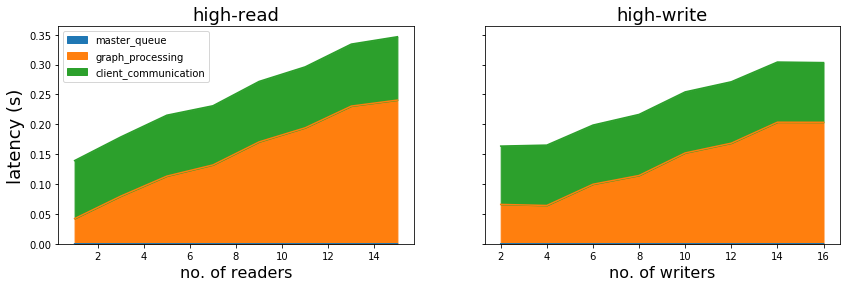

In [247]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,4), facecolor='white')
cols = ['num_readers','master_queue','graph_processing','client_communication']
# fig.suptitle('high-read', fontsize=24)
axes[0].set_ylabel('latency (s)', fontsize=18)
axes[0].set_title('high-read', fontsize=18)
axes[1].set_title('high-write', fontsize=18)
df_root_low[cols].plot(kind='area', x='num_readers', ax=axes[0])
axes[0].set_xlabel('no. of readers', fontsize=16)
cols = ['num_writers','master_queue','graph_processing','client_communication']
df_root_high[cols].plot(kind='area', x='num_writers', ax=axes[1], legend=False)
axes[1].set_xlabel('no. of writers', fontsize=16)
plt.show()

## High-load write requests

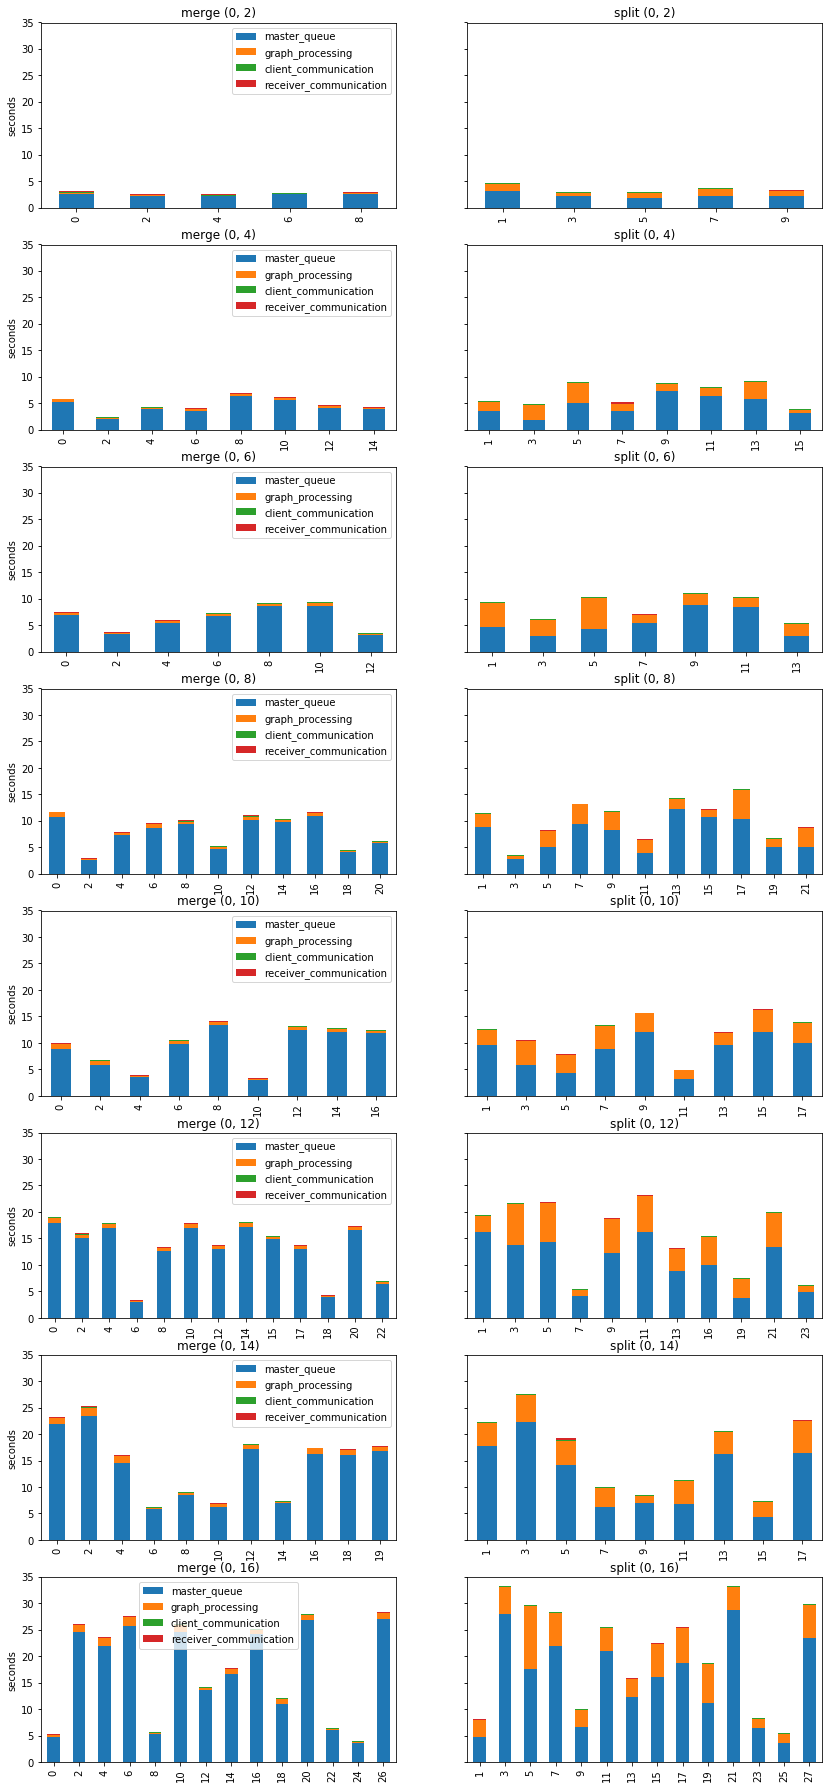

In [158]:
fig, axes = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(14,32), facecolor='white')
for i in range(8):
    plot_latency(axes[i], 0, (i+1)*2, read_requests=False)
plt.show()

## Low-load write requests

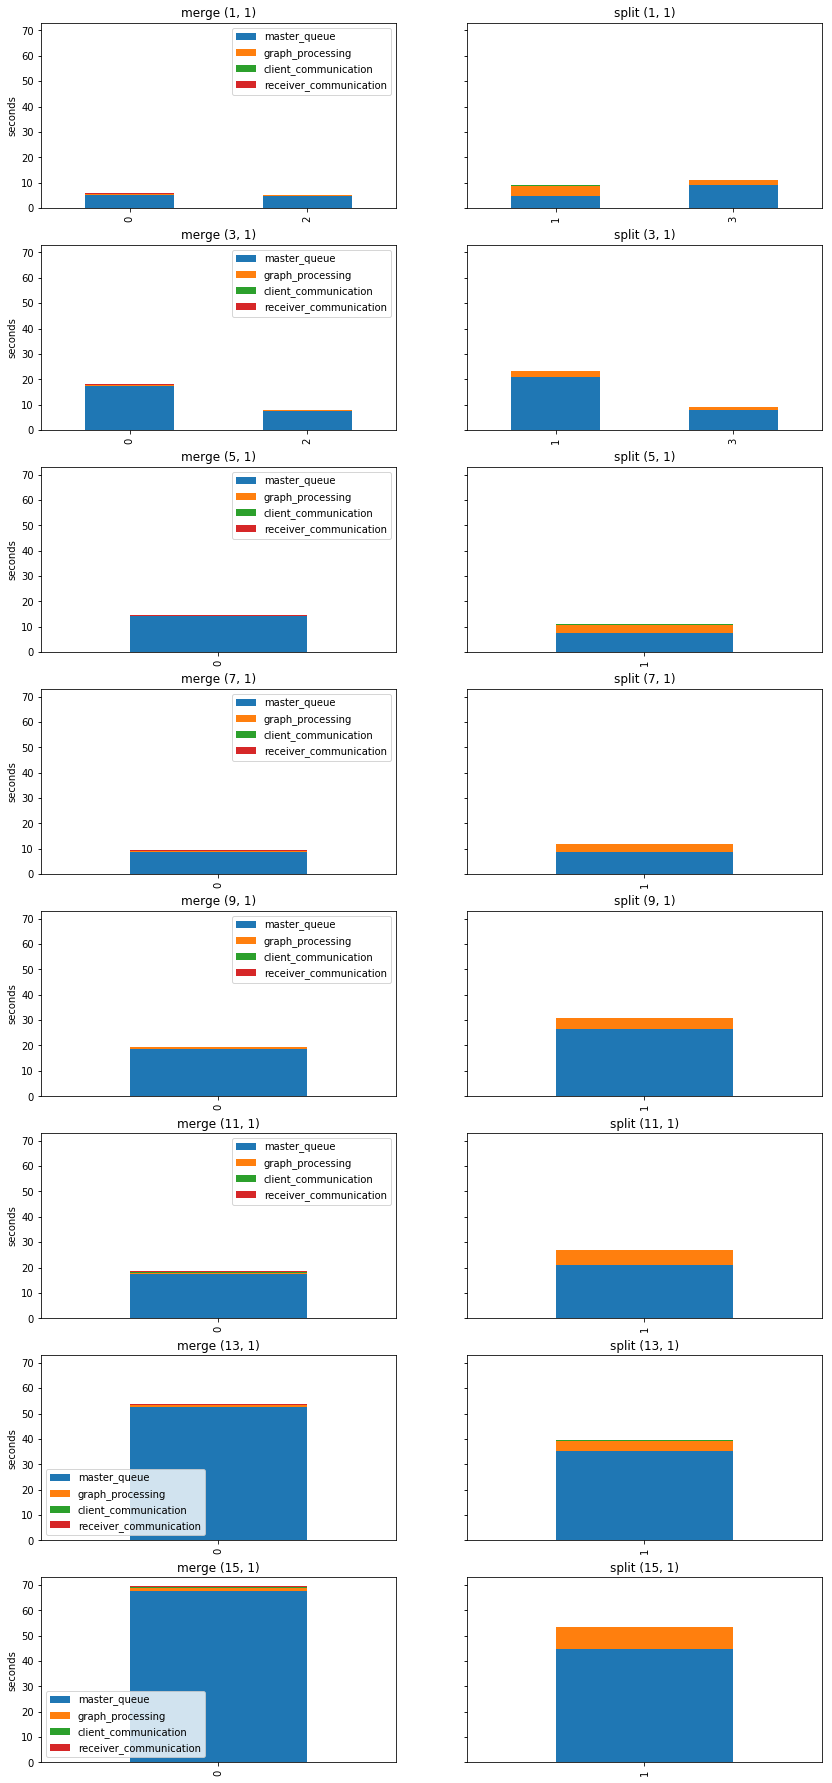

In [130]:
fig, axes = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(14,32), facecolor='white')
for i in range(8):
    plot_latency(axes[i], (i+1)*2-1, 1)
plt.show()

## High-load read requests

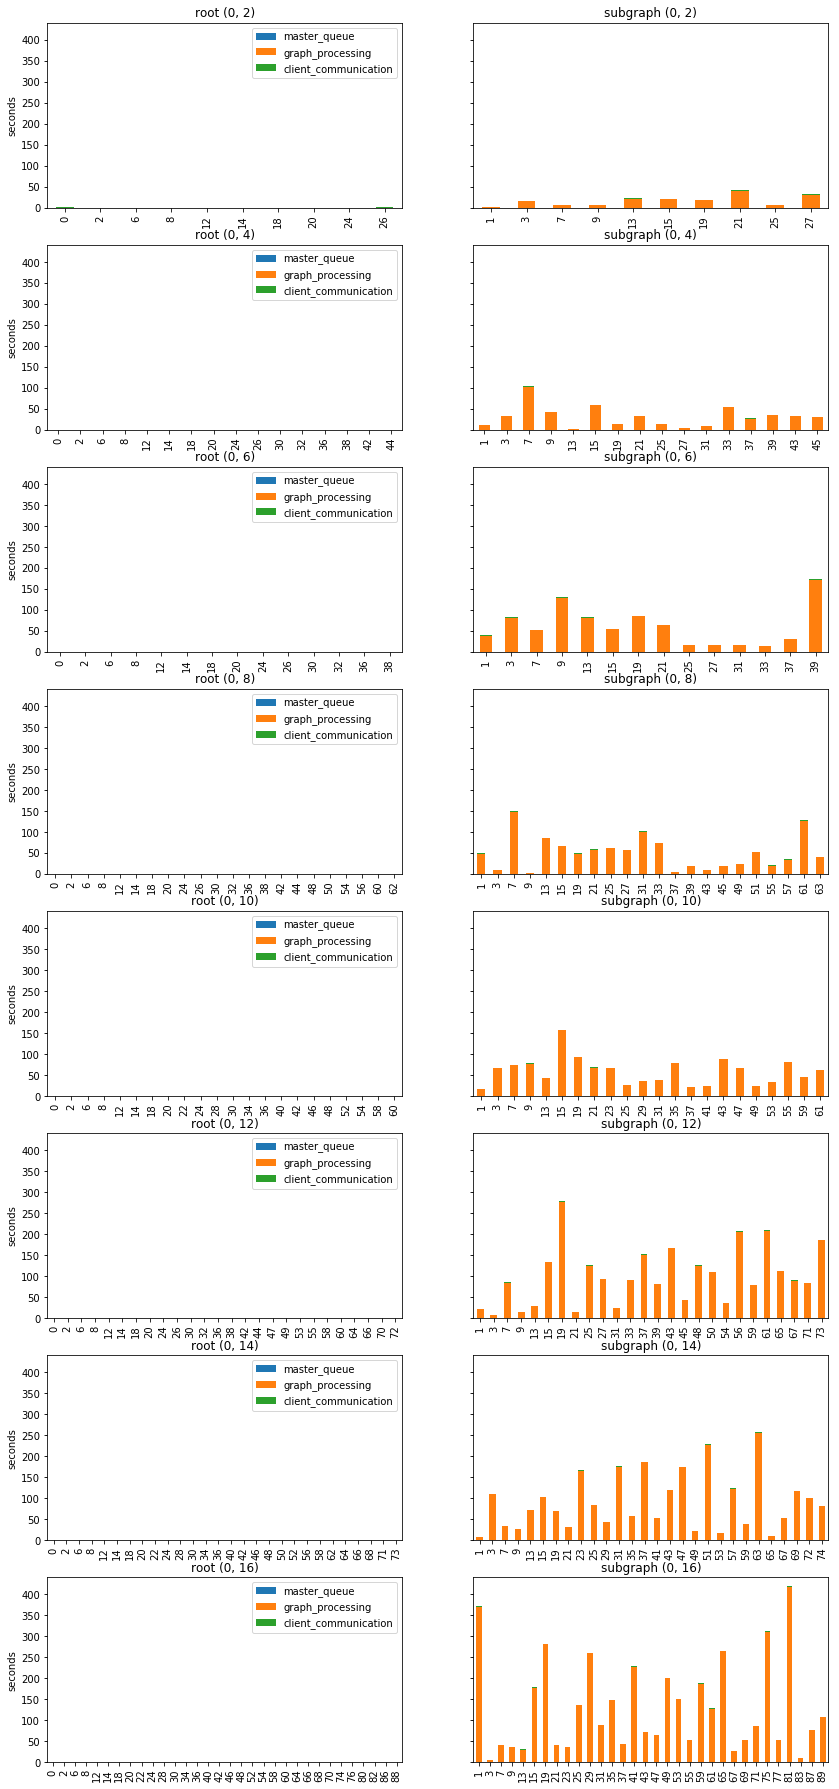

In [166]:
fig, axes = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(14,32), facecolor='white')
for i in range(8):
    plot_latency(axes[i], 0, (i+1)*2, read_requests=True)
plt.show()

## Low-load read requests

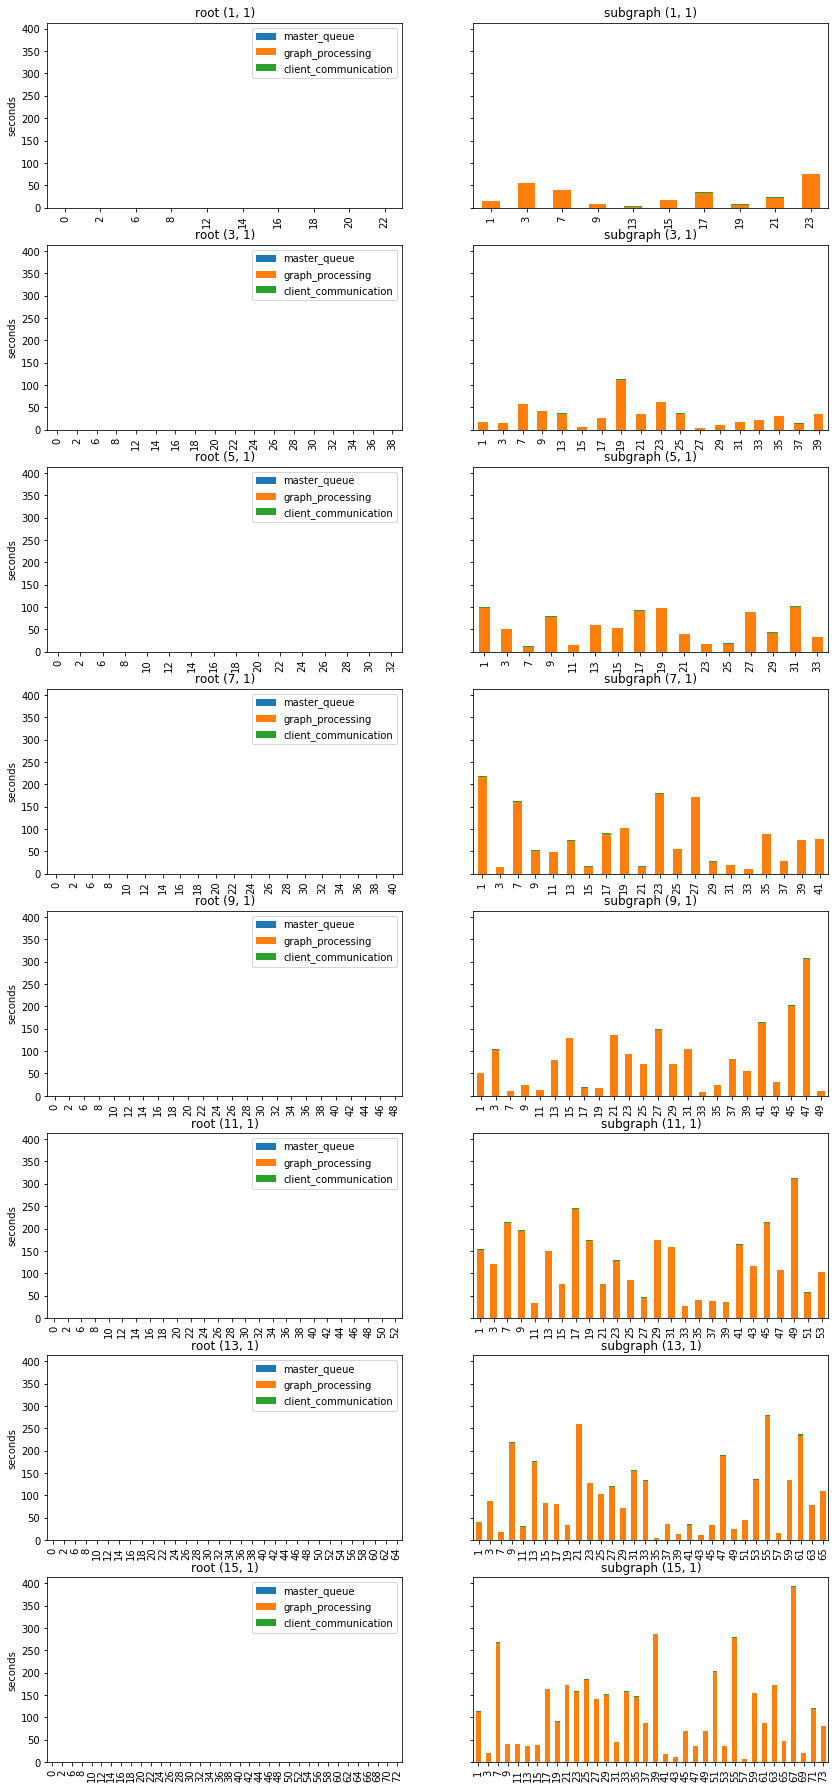

In [169]:
fig, axes = plt.subplots(nrows=8, ncols=2, sharey=True, figsize=(14,32), facecolor='white')
for i in range(8):
    plot_latency(axes[i], (i+1)*2-1, 1, read_requests=True)
plt.show()